# Use `Networkit` to speed up calculations

In [53]:
import networkit as nk
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import powerlaw

from utils import plot_powerlaw, show_weight, get_artist_name

# Reduce graph using `Graph Sampling` and `Edge Shedding`

## graph sampling

In [3]:
def graph_sampling(G, min_k=None, weight_threshold=None) -> nk.Graph:
    # Aplicar k-core sampling usando NetworKit
    kcore = nk.centrality.CoreDecomposition(G)
    kcore.run()
    max_core = kcore.maxCoreNumber()
    print(f"Max Core: {max_core}\n")

    # Ajustar el valor de min_k según sea necesario
    if min_k is None:
        min_k = max_core - 1  # Usar un k-core menor que el máximo

    # Filtrar el grafo para solo mantener nodos que pertenecen al k-core
    core_nodes = [n for n in range(G.numberOfNodes()) if kcore.score(n) >= min_k]

    # Si se proporciona un umbral de peso, filtrar también por peso
    if weight_threshold is not None:
        core_nodes = [n for n in core_nodes if G.nodeWeight(n) >= weight_threshold]

    k_core_graph = nk.graphtools.subgraphFromNodes(G, core_nodes)

    # Mostrar estadísticas del grafo reducido
    print(
        f"Nodos originales: {G.numberOfNodes()}, Nodos reducidos: {k_core_graph.numberOfNodes()}"
    )
    print(
        f"Aristas originales: {G.numberOfEdges()}, Aristas reducidas: {k_core_graph.numberOfEdges()}"
    )
    return k_core_graph

In [4]:
def graph_sampling_by_degree(G, sample_size):
    # Calcular el grado de cada nodo
    degrees = {i: G.degree(i) for i in range(G.numberOfNodes())}

    # Crear una lista de nodos y sus grados
    nodes = list(range(G.numberOfNodes()))
    node_degrees = [degrees[n] for n in nodes]

    # Calcular la probabilidad de selección basada en el grado
    total_degree = sum(node_degrees)
    probabilities = [degree / total_degree for degree in node_degrees]

    # Seleccionar nodos de manera aleatoria pero ponderada por su grado
    sampled_nodes = np.random.choice(
        nodes, size=sample_size, replace=False, p=probabilities
    )

    # Crear el subgrafo con los nodos seleccionados
    sampled_graph = nk.graphtools.subgraphFromNodes(G, sampled_nodes)

    # Mostrar estadísticas del grafo reducido
    print(
        f"Nodos originales: {G.numberOfNodes()}, Nodos reducidos: {sampled_graph.numberOfNodes()}"
    )
    print(
        f"Aristas originales: {G.numberOfEdges()}, Aristas reducidas: {sampled_graph.numberOfEdges()}"
    )
    return sampled_graph

## Edge shedding

In [5]:
def edge_shedding(G):
    # Copiar G
    graph = nk.Graph(G, weighted=True, directed=False)
    # Indexar aristas
    graph.indexEdges()
    # Obtener aristas del grafo con networkit
    betweenness = nk.centrality.Betweenness(graph)
    betweenness.run()
    edge_betweenness = betweenness.edgeScores()

    iter = graph.iterEdges()
    # Obtener aristas con pesos en una línea
    edges = [(u, v, graph.weight(u, v)) for u, v in iter]
    # Asegurarse de que los IDs de las aristas estén dentro del rango
    edges_sorted = sorted(
        edges,
        key=lambda e: (
            edge_betweenness[graph.edgeId(e[0], e[1])]
            if graph.edgeId(e[0], e[1]) < len(edge_betweenness)
            else 0
        ),
        reverse=True,
    )
    p = 0.3  # Proporción de aristas a preservar
    num_edges_to_keep = int(p * G.numberOfEdges())

    # Crear el grafo reducido
    G_reduced = nk.graph.Graph(n=graph.numberOfNodes(), weighted=True, directed=False)

    # Agregar todos los nodos al grafo reducido
    for node in range(graph.numberOfNodes()):
        G_reduced.addNode()

    # Agregar las aristas preservadas al grafo reducido
    for i in range(num_edges_to_keep):
        u, v, w = edges_sorted[i]
        G_reduced.addEdge(u, v, w)

    # Mostrar estadísticas del grafo reducido
    print(f"Aristas eliminadas: {len(edges_sorted) - num_edges_to_keep}")
    print(f"Nodos: {G_reduced.numberOfNodes()}, Aristas: {G_reduced.numberOfEdges()}")
    return G_reduced

# Process data

## Read `CSV`'s and join

In [6]:
# read with networkx
filename = f"../datasets/edges/ArtistW.csv"
print(f"Reading {filename}")
G = nx.read_edgelist(
    filename,
    nodetype=str,
    delimiter=";",
    create_using=nx.Graph(),
    data=(('weight', int),) # type: ignore
)

In [7]:
# Save index of the artists
artists = {}
for i,node in enumerate(G):
    artists[node] = i

In [8]:
G.number_of_nodes()

20357

In [9]:
# Create an empty Networkit graph
G_nk = nk.Graph(weighted=True, directed=False)

# Add nodes to the Networkit graph
G_nk.addNodes(G.number_of_nodes())

# Add edges with weights to the Networkit graph
for u, v, data in G.edges(data=True):
    G_nk.addEdge(artists[u], artists[v], data["weight"])
G = G_nk
del G_nk

In [10]:
# make graph undirected
print(f"Nodes: {G.numberOfNodes()}, Edges: {G.numberOfEdges()}, Self Loops: {G.numberOfSelfLoops()}")
G.removeSelfLoops()
show_weight(G)

Nodes: 20357, Edges: 518214, Self Loops: 2
Max Weight: 32212.0
Min Weight: 11.0
Average Weight: 62.418882619468484


Graph


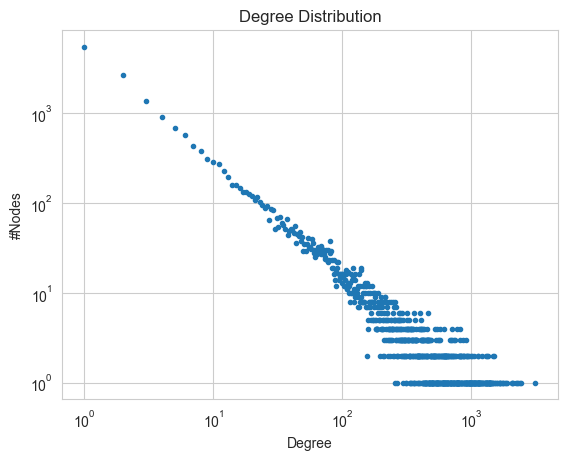

In [11]:
print("Graph")
plot_powerlaw(G)

Graph Sampling
Nodos originales: 20357, Nodos reducidos: 10000
Aristas originales: 518212, Aristas reducidas: 491114
Max Weight: 32212.0
Min Weight: 11.0
Average Weight: 64.60512223231267


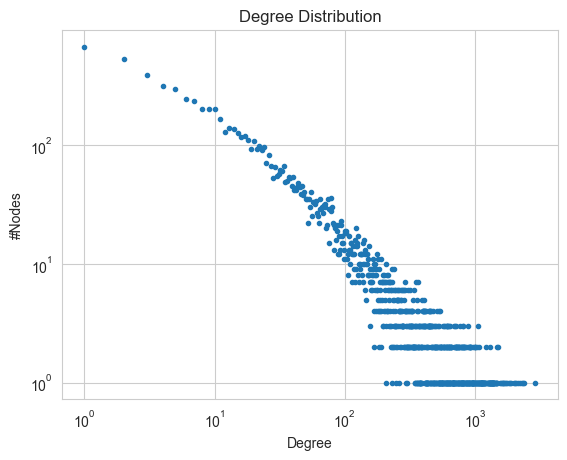

In [12]:
print("Graph Sampling")
G = graph_sampling_by_degree(G,10000)
show_weight(G)
plot_powerlaw(G)


Edge Shedding
Aristas eliminadas: 343780
Nodos: 20000, Aristas: 147334
Max Weight: 32212.0
Min Weight: 11.0
Average Weight: 93.80751218320279


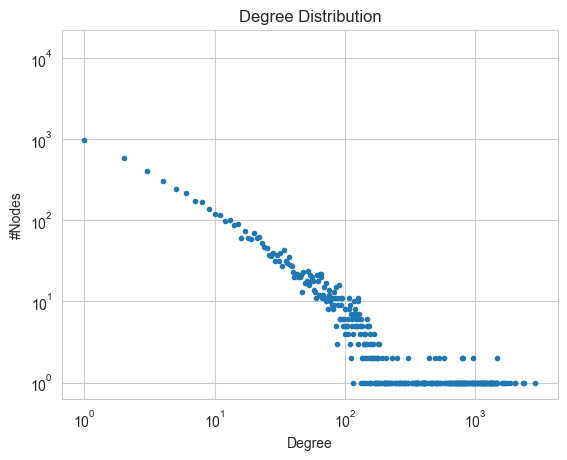

In [13]:
print("Edge Shedding")
G = edge_shedding(G)
show_weight(G)
plot_powerlaw(G)

# Plot Graph

In [14]:
def generate_rgb(seed: int) -> str:
    # return "#xxxxx"
    random.seed(seed)
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return f"#{r:02x}{g:02x}{b:02x}"

In [39]:
# Generate g with weights 
g = nx.Graph()
for u, v, data in G.iterEdgesWeights():
    g.add_edge(u, v, weight=data)

In [40]:
nodes_size = [g.degree(node) * 1.65 for node in g.nodes()]

In [41]:
hubs, _ = nx.hits(g, max_iter=100, tol=1e-08, normalized=True)
# hubs = set(hubs.keys())

# Ordenar los nodos por sus puntajes de hub en orden descendente
sorted_hubs = sorted(hubs.items(), key=lambda item: item[1], reverse=True)

# Definir cuántos hubs principales seleccionar (ejemplo: top 3 hubs)
top_n = 10
top_hubs = sorted_hubs[:top_n]

# Mostrar los principales hubs
print(f"Top {top_n} Hubs:")
for node, score in top_hubs:
    print(f"Nodo {node}: Puntaje de hub {score}")

Top 10 Hubs:
Nodo 211: Puntaje de hub 0.04140081390586353
Nodo 224: Puntaje de hub 0.021896290312504132
Nodo 540: Puntaje de hub 0.017638406390783033
Nodo 538: Puntaje de hub 0.01744084519433345
Nodo 212: Puntaje de hub 0.016968311632069098
Nodo 219: Puntaje de hub 0.01645493766148753
Nodo 109: Puntaje de hub 0.01570377750436845
Nodo 210: Puntaje de hub 0.014999360375096893
Nodo 229: Puntaje de hub 0.01407623823837996
Nodo 204: Puntaje de hub 0.013462708064114945


In [42]:
# see artist with hubs
print("Top Hubs")
for node, score in top_hubs:
    print(f"Node: {node}, Score: {score}")
    print(f"Artist: { get_artist_name(node,artists)}")

Top Hubs
Node: 211, Score: 0.04140081390586353
Artist: Drake
Node: 224, Score: 0.021896290312504132
Artist: Kendrick_Lamar
Node: 540, Score: 0.017638406390783033
Artist: Future
Node: 538, Score: 0.01744084519433345
Artist: Kanye_West
Node: 212, Score: 0.016968311632069098
Artist: Big_Sean
Node: 219, Score: 0.01645493766148753
Artist: J._Cole
Node: 109, Score: 0.01570377750436845
Artist: Rihanna
Node: 210, Score: 0.014999360375096893
Artist: Migos
Node: 229, Score: 0.01407623823837996
Artist: Rae_Sremmurd
Node: 204, Score: 0.013462708064114945
Artist: Post_Malone


In [43]:
hubs = [node for node, _ in top_hubs]

In [44]:
nodes_color = [generate_rgb(100) if node in hubs else generate_rgb(120)  for node in g.nodes()]

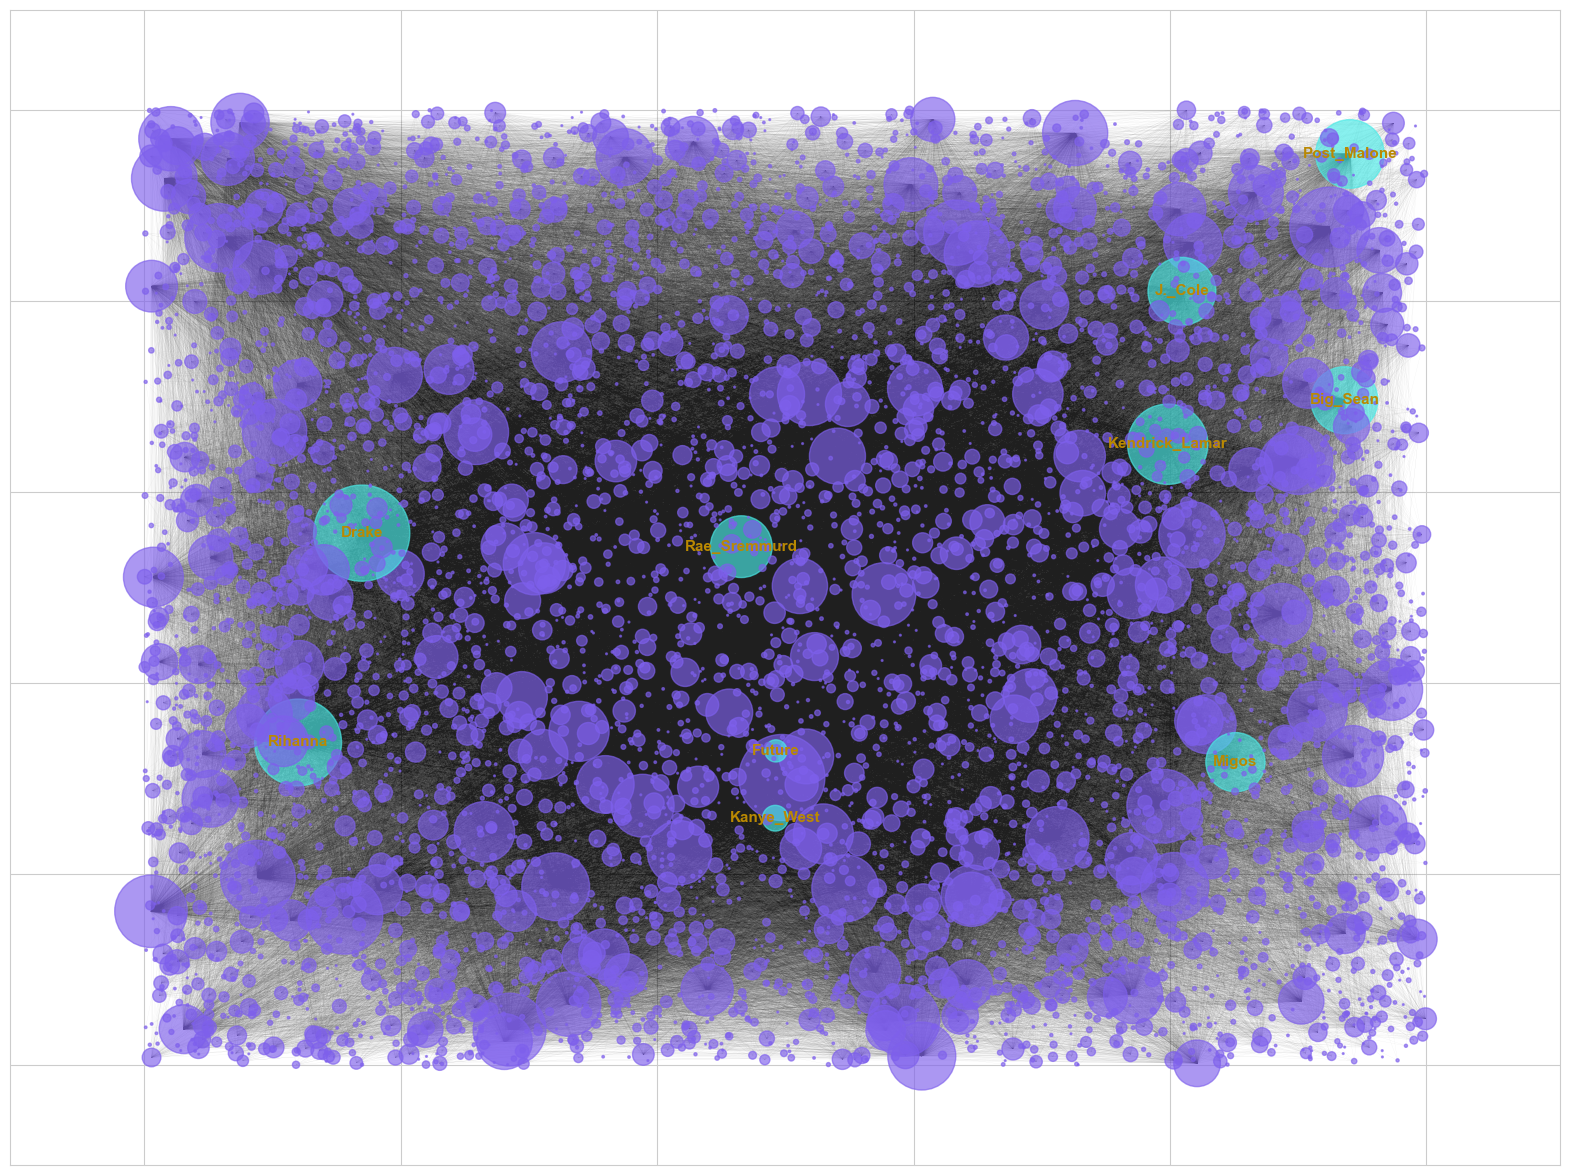

In [75]:
# Aumentar el tamaño de la figura
plt.figure(figsize=(20, 15))

# Calcular la posición de los nodos
pos = nx.random_layout(g, seed=42)

# Dibujar los nodos
nx.draw_networkx_nodes(g, pos, node_size=nodes_size, node_color=nodes_color, alpha=0.65)  # type: ignore

# Dibujar las aristas
nx.draw_networkx_edges(g, pos, width=0.1, alpha=0.1, edge_color="#1f1f1f")

# Dibujar etiquetas para los hubs
nx.draw_networkx_labels(
    g,
    pos,
    labels={node: get_artist_name(node, artists) for node in hubs},
    font_size=11,
    font_color="#ba8902",
    font_weight="bold",
)

# Mostrar la gráfica
plt.show()

Calculating best minimal value for power law fit


C:\Users\pms_l\AppData\Local\Temp\ipykernel_60960\709222175.py:18: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(min(degree), max(degree))


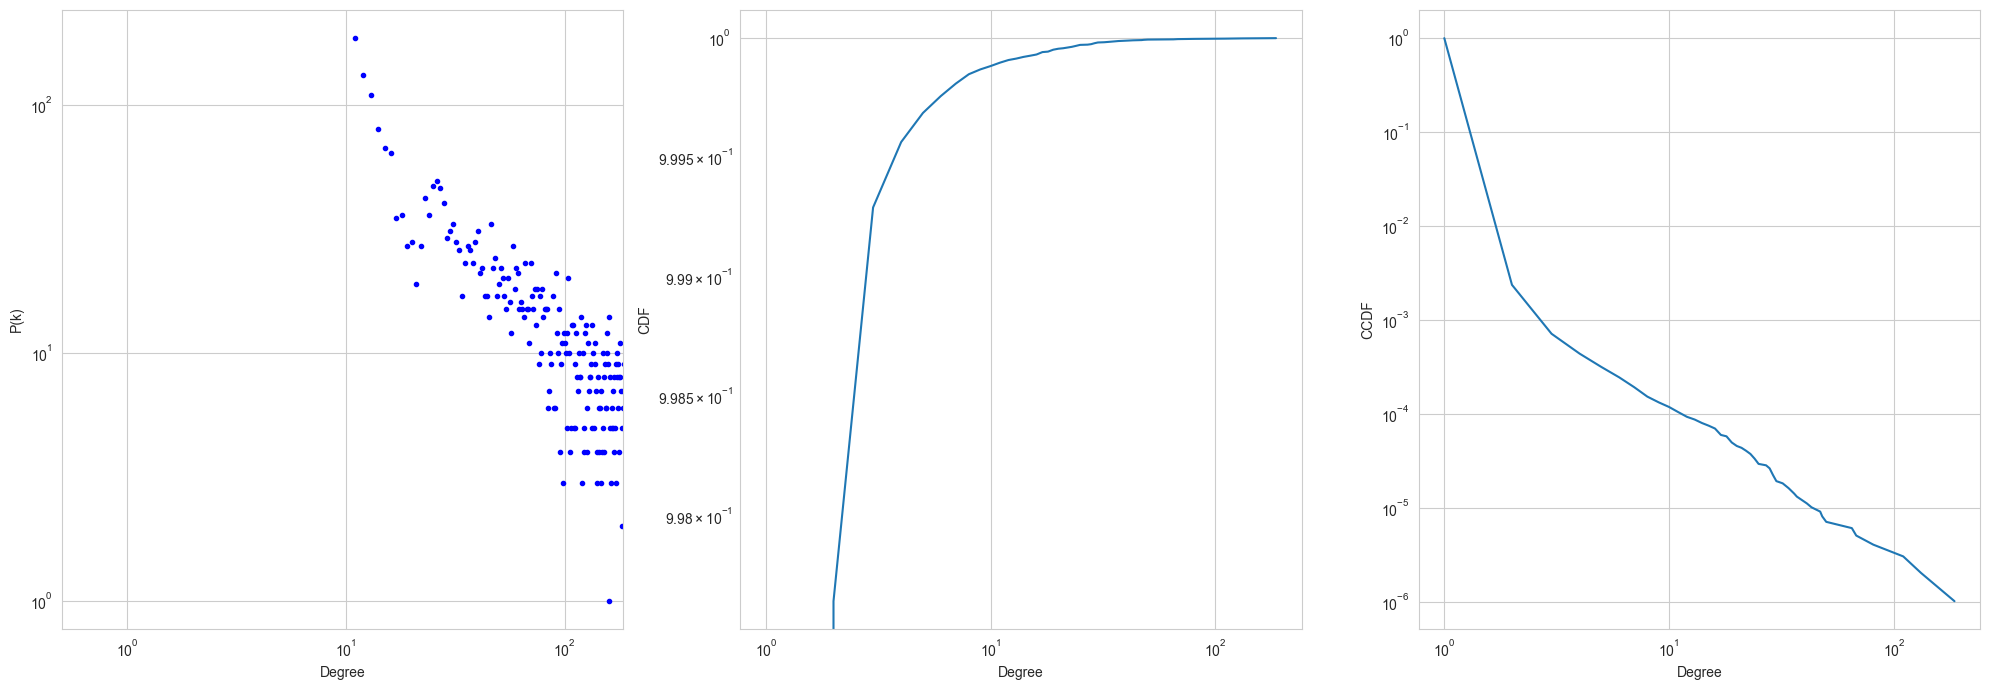

In [86]:
def plot_dist(G):
    M = nx.to_scipy_sparse_array(
        G
    )  # Convertimos el grafo a una matriz dispersa de scipy
    xmin = min([d[1] for d in G.degree()])
    indegrees = M.sum(0)  # Suma de los grados de entrada
    degree = np.bincount(
        indegrees.astype(int)
    )  # Asegúrate de convertir los grados a enteros
    fit = powerlaw.Fit(np.array(degree) + 1, fit_method="KS")

    fig = plt.figure(figsize=(20, 7))

    """ Plot Distribution """
    plt.subplot(1, 3, 1)
    plt.plot(range(len(degree)), degree, "b.")
    plt.loglog()
    plt.xlim(min(degree), max(degree))
    plt.xlabel("Degree")
    plt.ylabel("P(k)")

    """ Plot CDF """
    plt.subplot(1, 3, 2)
    fit.plot_cdf()
    plt.xlabel("Degree")
    plt.ylabel("CDF")

    """ Plot CCDF """
    plt.subplot(1, 3, 3)
    fit.plot_ccdf()
    plt.xlabel("Degree")
    plt.ylabel("CCDF")

    plt.tight_layout()
    plt.show()


# Ahora puedes llamar a la función con tu grafo g
plot_dist(g)

In [79]:
# save graph
filename = f"../datasets/edges/ArtistW_sample.csv"
print(f"Saving {filename}")
nx.write_edgelist(
    g,
    filename,
    delimiter=";",
    data=["weight"],
    encoding="utf-8",
)
# save artist index in json
filename = f"../datasets/edges/ArtistW_index.json"
print(f"Saving {filename}")
import json

with open(filename, "w") as f:
    json.dump(artists, f)

Saving ../datasets/edges/ArtistW_sample.csv
Saving ../datasets/edges/ArtistW_index.json


## See comunity structure